# Purpose of this notebook

This notebook is to replicate the Lind paper as we did not do this in the previous notebooks. In particular, we want to look at 

# import the files and functions

In [1]:
# import packages and functions
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

import matplotlib.dates as mdates
import matplotlib.colors as mcolors

%run /home/mmurakami/crios_backups/an_helper_functions/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [ ]:
dirIncopy = dirIn.copy()

In [57]:
dirIn = "/scratch3/atnguyen/aste_270x450x180/run_c68v_adxOFF_20022023_capxxN50_it0062_pk0000000007_bro/diags/BUDG"

In [58]:
# # load the landmask
hfac = mygrid['hFacC']
landmsk = hfac[0]
landmsk[np.isnan(landmsk)] = 2
landmsk[landmsk == 1] = np.nan

In [59]:
mygrid['Depth'].shape

(1350, 270)

(450.0, 540.0)

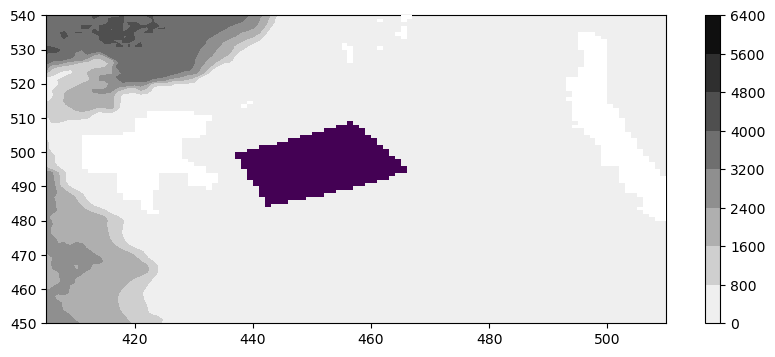

In [60]:
a = np.full(mskBasin.shape,np.nan)
# a[525:555:,35:55] = 1

# create the mask based on lat long
lon = mygrid['XC']
lat = mygrid['YC']
mask = np.zeros_like(lat)
mask[(lat >= 76.25) & (lat <= 78.5) & (lon >= 27) & (lon <= 41)] = 1  # Masked region
mask[mask == 0 ] = np.nan



fig = plt.figure()

# cb = plt.pcolormesh(get_aste_tracer(mygrid['Depth'],nfx,nfy)[0],cmap="gray_r",vmin=0,vmax=300)
cb = plt.contourf(get_aste_tracer(mygrid['Depth'],nfx,nfy)[0],cmap="gray_r")
plt.colorbar(cb)

plt.pcolormesh(get_aste_tracer(mask,nfx,nfy)[0],zorder=2)
plt.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],zorder=4,cmap="gray_r")

plt.xlim(405,510)
plt.ylim(450,540)

In [61]:
# check the size of this with RAC
# Lind paper uses a size of 85,000 km^2
RACkm2 = RAC * 1e-6 # km^2
np.nansum(RACkm2*mask)

85495.45221037403

In [62]:
np.savez('mask_Lind.npz', msk1=mask)

# load this from the file and plot the timeseries of this

In [63]:
# add the isopycnals
# add the density contours from gsw
smin = 25.5 - (0.01 * 25.5)    #salt_ctrl_subregR.min - (0.01 * salt_ctrl_subregR.min)
smax = 36 + (0.01 * 36)    #salt_ctrl_subregR.max + (0.01 * salt_ctrl_subregR.max)
tmin = -2 + (0.1 * -2)       #temp_ctrl_subregR.min - (0.1 * temp_ctrl_subregR.max)
tmax = 31 + (0.1 * 31)       #temp_ctrl_subregR.max + (0.1 * temp_ctrl_subregR.max)
print('tmin, tmax, smin, smax sizes=,', tmin, tmax, smin, smax)
# Calculate how many gridcells we need in the x and y dimensions
xdim = 50
ydim = 50
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(-2,31,ydim)
si = np.linspace(25.5,36,xdim)
Freez_temp = gsw.CT_freezing(si,0,0)

Si, Ti = np.meshgrid(si, ti, sparse=False, indexing='ij')
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        #print(si[i],ti[j])
        dens[j,i]=gsw.rho(si[i],ti[j],0)
        # Substract 1000 to convert to sigma-0
dens2 = dens - 1000

tmin, tmax, smin, smax sizes=, -2.2 34.1 25.245 36.36


In [64]:
mymsk = np.load('mask_Lind.npz')
mymsk = mymsk['msk1']

In [65]:
# copy the files we need from the timeseries, make sure we know what we're looking at
# get the timesteps for the year 2007
# ocean and ice
AB_gT=0
AB_gS=0
dt_aste = 600
startyr = 2002
endyr = 2019              # for ASTE R1

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)
allyears = np.arange(2003,2018,1)

In [66]:
# np.cumsum(mygrid['DRF'][0:10])
heat_content = np.full((len(allyears),12,ny,nx),np.nan)
fw_content = np.full((len(allyears),12,ny,nx),np.nan)

In [67]:
# loop through the years to create the timeseries
# alldatetimes = np.array([])
# FW_times = np.array([])
# Heat_times = np.array([])  # this does not make sense as variable name
dstart = 0
dterm = 10
# sref = 36.25
# tref = -1.95

# from Lind Paper
sref = 35
tref = 0

iy = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    # get the theta/salt values
    # we also want salt to do the FW content
    # we want temperature and salt
    THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
    SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'budg3d_snap_set2'
        meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_budg3d_snap_set2["fldList"])
        varnames = np.array(["THETADR","SALTDR"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETADRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
        SALTDRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])  # degC.m
    
        THETADR[i,:,:,:] = np.reshape(THETADRi,(nz,ny,nx))
        SALTDR[i,:,:,:] = np.reshape(SALTDRi,(nz,ny,nx))

    # get theta and salt alone so we can use for the freshwater content
    THETA = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
    SALT = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
        THETA[i,:,:,:] = THETADR[i,:,:,:]/DRF3d/mygrid['hFacC']  # degC
        SALT[i,:,:,:]  = SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC']   # PSU

    ##########################################################################################
    # get the heat content
    for i in range(len(datetimes)):
        # for calculating heat content:
            # weighted theta * rcp = J/m^2 which is the depth-weighted heat content of a cell
            # integrate over all values within the depth interval of choice
        
        thisTHETA = THETADR[i]/DRF3d/mygrid['hFacC'] * mymsk[np.newaxis,:,:]    # degC
        thisheat = (thisTHETA - tref) * myparms['rcp']   # degC * J/m^3.degC = J/m^3
        thisheat = thisheat * DRF3d  # J/m³ * m = J/m²

        # select heat based on the AW layer
        thisheat = thisheat[dstart:dterm]   # upper mygrid['DRF'][:dterm] m
        heat_content_2D = np.nansum(thisheat,axis=0) * mymsk         # vertical integration (J/m^2)

        # do the spatial averaging
        # area_masked = RAC * mymsk   # m^2
        # heat_content_avg = np.nansum(heat_content_2D * area_masked)/np.nansum(area_masked)   # MJ/m^2 * m^2/m^2
        heat_content[iy,i,:,:] = heat_content_2D * 1e-6  # MJ/m^2

    ##########################################################################################
    # get the freshwater content values
    # set up for time averaging
    # filter = drf3d.copy() * mygrid['hFacC']
    # filter[filter >= 254] = np.nan
    # filter[filter < 254] = 1
    FWcontent = np.full((len(tsstr),ny,nx),np.nan)
    
    for i in range(len(tsstr)): 
        # for calculating freshwater content:
            # FW volume * (1- salinity/reference salinity)    m^3
            # integrate over surface to mygrid['DRF'][:dterm] m based on the np.where(np.cumsum(mygrid['DRF'])<X meters deep)
            # look at the time average of this
        
        # do step 1 to get FW volume and only look at the values at less than X m
        FWvol = ((sref - SALT[i])/sref) * DRF3d # m
        
        FWvol = FWvol[dstart:dterm]    # leaving as m^3 here
        
        # vertically integrate
        FWcontent_2D = np.nansum(FWvol,axis=0) * mymsk          # vertical integration, m
        # area_masked = RAC * mymsk
        # FW_content_avg = np.nansum(FWcontent_2D * area_masked)/np.nansum(area_masked)

        # add as a map to the bigger array
        fw_content[iy,i,:,:] = FWcontent_2D

    print()
    iy += 1

2003


FileNotFoundError: [Errno 2] No such file or directory: '/scratch3/atnguyen/aste_270x450x180/run_c68v_adxOFF_20022023_capxxN50_it0062_pk0000000007_bro/diags/BUDGbudg3d_snap_set2.0000052560.meta'

In [17]:
# for i in range(len(datetimes)):
#     # for calculating heat content:
#         # weighted theta * rcp = J/m^2 which is the depth-weighted heat content of a cell
#         # integrate over all values within the depth interval of choice
    
#     thisTHETA = THETADR[i]/DRF3d/mygrid['hFacC'] * mymsk[np.newaxis,:,:]    # degC
#     thisheat = (thisTHETA - tref) * myparms['rcp'] *1e-6   # degC * J/m^3.degC = J/m^3
#     thisheat = thisheat * DRF3d  # J/m^2
#     print(np.nanmean(thisheat))

#     # select heat based on the AW layer
#     thisheat = thisheat[dstart:dterm]   # upper mygrid['DRF'][:dterm] m
#     heat_content_2D = np.nansum(thisheat,axis=0) * mymsk         # vertical integration (J/m^2)
#     print(np.nanmean(heat_content_2D))

#     # do the spatial averaging
#     area_masked = RAC * mymsk   # m^2
#     heat_content_avg = np.nansum(heat_content_2D * area_masked)/np.nansum(area_masked)   # MJ/m^2 * m^2/m^2
#     print(np.nanmean(heat_content_avg))
#     heat_content[iy,i,:,:] = heat_content_avg  # MJ/m^2


In [41]:
heat_climatology.shape

(15, 12, 1350, 270)

In [44]:
heat_content_time = np.nanmean(heat_content,axis=(2,3))
heat_climatology = np.tile(np.nanmean(heat_content, axis=0)[np.newaxis,:,:,:],(len(allyears),1,1,1))
heat_climatology_time = np.nanmean(heat_climatology,axis=(2,3))
fw_content_time = np.nanmean(fw_content,axis=(2,3))
fw_climatology = np.tile(np.nanmean(fw_content,axis=0)[np.newaxis,:,:,:],(len(allyears),1,1,1))
fw_climatology_time = np.nanmean(fw_climatology,axis=(2,3))

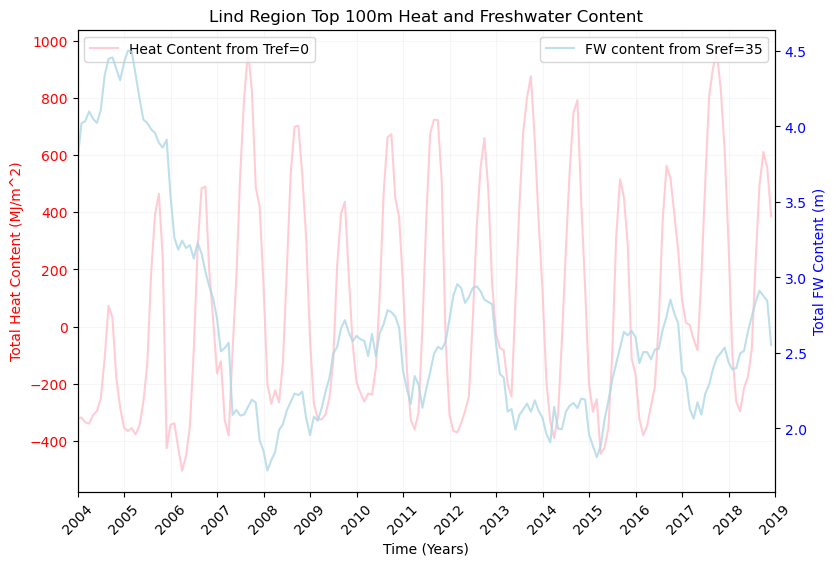

In [21]:
# plot these for the little Lind mask
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(9, 6))

# Time axis
time = np.arange(0, 15*12, 1)

# Plot heat content on primary y-axis (left)
ax1.plot(time, heat_content_time.flatten(), color="pink", alpha=0.8, label="Heat Content from Tref=0")
ax1.set_ylabel("Total Heat Content (MJ/m^2)", color="red")
ax1.tick_params(axis='y', labelcolor="red")

# Create second y-axis for freshwater content (right)
ax2 = ax1.twinx()
ax2.plot(time, fw_content_time.flatten(), color="lightblue", alpha=0.8, label="FW content from Sref=35")
ax2.set_ylabel("Total FW Content (m)", color="blue")
ax2.tick_params(axis='y', labelcolor="blue")

# X-axis labels and title
ax1.set_xlabel("Time (Years)")
ax1.set_title("Lind Region Top 100m Heat and Freshwater Content")

# X-axis ticks
xtick_positions = np.arange(0, 20*12, 12)  # Every 12 months
xtick_labels = np.arange(2004, 2024)  # Years from 2004 to 2023
ax1.set_xticks(xtick_positions)
ax1.set_xticklabels(xtick_labels, rotation=45)  # Rotate for readability
ax1.set_xlim(0, 15*12)
ax1.grid(alpha=0.1)

# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# Save and show plot
# plt.savefig("Lind_AWlayer_Newgion_timeseries.png", dpi=300)
plt.show()

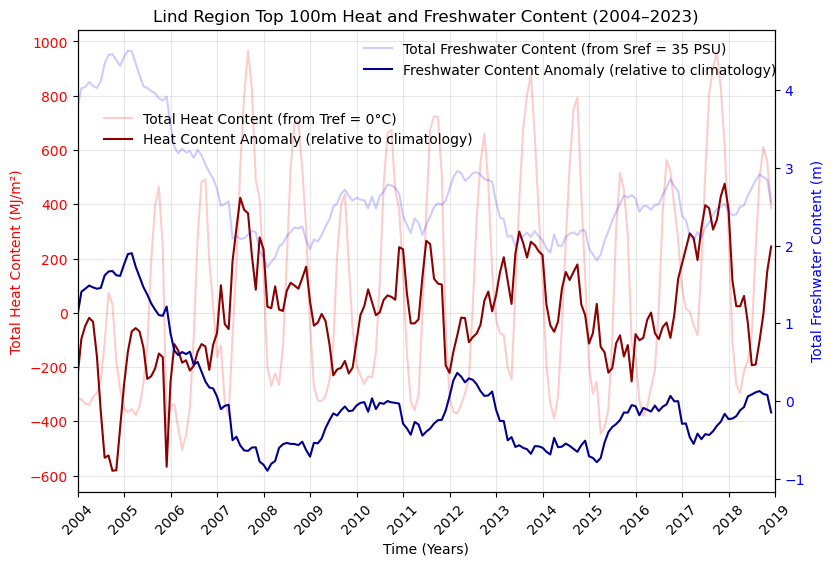

In [65]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(9, 6))

# Time axis (assuming monthly data for 2004-2023)
time = np.arange(0, 15 * 12, 1)

# Plot heat content on primary y-axis (left)
ax1.plot(time, heat_content_time.flatten(), color="red", alpha=0.2, label="Total Heat Content (from Tref = 0°C)")
ax1.plot(time, (heat_content_time - heat_climatology_time).flatten(), color="darkred", alpha=1, label="Heat Content Anomaly (relative to climatology)")

# Formatting for heat content axis
ax1.set_ylabel("Total Heat Content (MJ/m²)", color="red")
ax1.tick_params(axis='y', labelcolor="red")

# Create second y-axis for freshwater content (right)
ax2 = ax1.twinx()
ax2.plot(time, fw_content_time.flatten(), color="blue", alpha=0.2, label="Total Freshwater Content (from Sref = 35 PSU)")
ax2.plot(time, (fw_content_time - fw_climatology_time).flatten(), color="darkblue", alpha=1, label="Freshwater Content Anomaly (relative to climatology)")

# Formatting for freshwater content axis
ax2.set_ylabel("Total Freshwater Content (m)", color="blue")
ax2.tick_params(axis='y', labelcolor="blue")

# X-axis labels and title
ax1.set_xlabel("Time (Years)")
ax1.set_title("Lind Region Top 100m Heat and Freshwater Content (2004–2023)")

# X-axis ticks
xtick_positions = np.arange(0, 20 * 12, 12)  # Every 12 months
xtick_labels = np.arange(2004, 2024)  # Years from 2004 to 2023
ax1.set_xticks(xtick_positions)
ax1.set_xticklabels(xtick_labels, rotation=45)  # Rotate for readability
ax1.set_xlim(0, 15 * 12)
ax1.grid(alpha=0.3)


# Move one legend lower to avoid overlap
ax1.legend(loc="upper left", bbox_to_anchor=(0.02, 0.85), frameon=False)  # Slightly lower
ax2.legend(loc="upper right", bbox_to_anchor=(1.02, 1), frameon=False)  # Default position


# Save and show plot
plt.savefig("Lind_AWlayer_Heat_FW_Timeseries.png", dpi=300, bbox_inches="tight")
plt.show()

In [68]:
# create one where we average year by year
heat_content2 = np.nanmean(heat_content,axis=1)
heat_content_time = np.nanmean(heat_content2,axis=(1,2))
fw_content2 = np.nanmean(fw_content,axis=1)
fw_content_time = np.nanmean(fw_content2,axis=(1,2))
fw_content_time.shape

(15,)

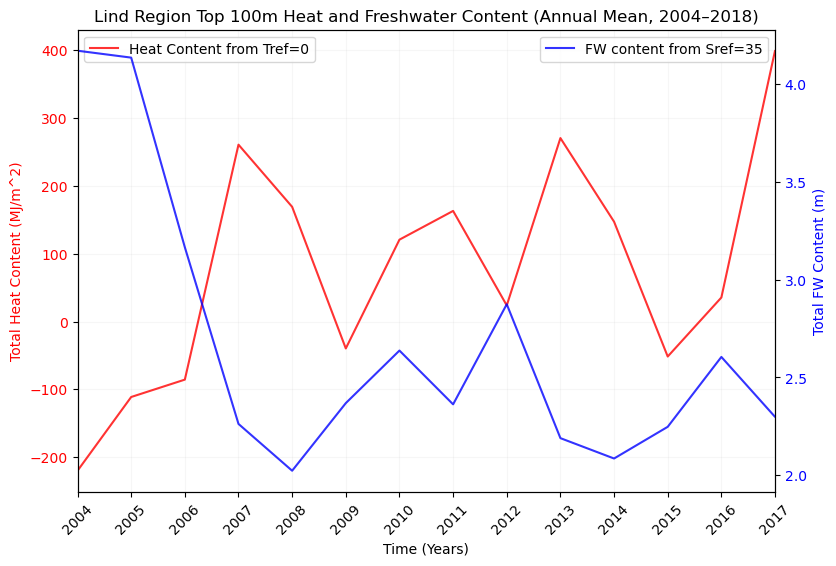

In [72]:
# plot these for the little Lind mask
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(9, 6))

# Time axis
time = np.arange(0, 15, 1)

# Plot heat content on primary y-axis (left)
ax1.plot(time, heat_content_time.flatten(), color="red", alpha=0.8, label="Heat Content from Tref=0")
ax1.set_ylabel("Total Heat Content (MJ/m^2)", color="red")
ax1.tick_params(axis='y', labelcolor="red")

# Create second y-axis for freshwater content (right)
ax2 = ax1.twinx()
ax2.plot(time, fw_content_time.flatten(), color="blue", alpha=0.8, label="FW content from Sref=35")
ax2.set_ylabel("Total FW Content (m)", color="blue")
ax2.tick_params(axis='y', labelcolor="blue")

# X-axis labels and title
ax1.set_xlabel("Time (Years)")
ax1.set_title("Lind Region Top 100m Heat and Freshwater Content (Annual Mean, 2004–2018)")

# X-axis ticks
xtick_positions = np.arange(0, 15, 1)  # Every 12 months
xtick_labels = np.arange(2004, 2019)  # Years from 2004 to 2023
ax1.set_xticks(xtick_positions)
ax1.set_xticklabels(xtick_labels, rotation=45)  # Rotate for readability
ax1.set_xlim(0, 13)
ax1.grid(alpha=0.1)

# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# Save and show plot
plt.savefig("Lind_AWlayer_Heat_FW_Timeseries_annualavg.png", dpi=300)
plt.show()

# plot the maps based on changes between 2004 to 2016 and the outline of the mask

In [73]:
# # Compute climatology: average for each month over all years
# num_years = 15
# num_months = 12

# # Reshape into (years, months) for computing monthly means
# heat_content_clim = heat_content_time.reshape(num_years, num_months).mean(axis=0)
# fw_content_clim = fw_content_time.reshape(num_years, num_months).mean(axis=0)

# # Expand climatology back to full time series length
# heat_content_anom = heat_content_time.flatten() - np.tile(heat_content_clim, num_years)
# fw_content_anom = fw_content_time.flatten() - np.tile(fw_content_clim, num_years)


# use the theta profile to get draw a line for the division between layers

In [12]:
# first create the masks for the layers in map view
hfC = mygrid['hFacC']
hfC0 = hfC[0]
hfC0_copy = np.full((ny,nx),np.nan)
hfC0_copy[np.isnan(hfC0)] = 1

hfC[0] = hfC0_copy

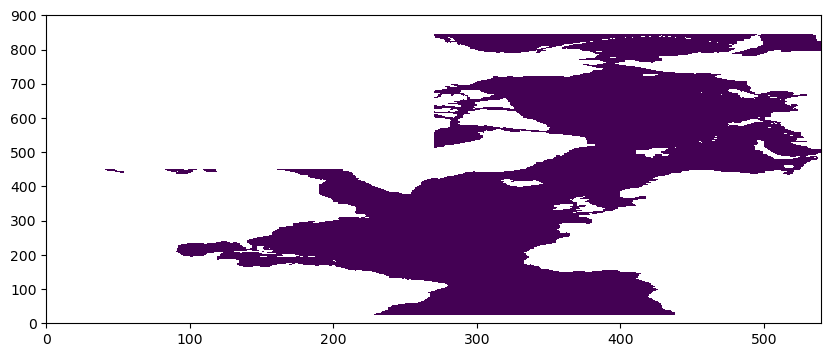

In [13]:
plt.pcolormesh(get_aste_tracer(hfC,nfx,nfy)[0])

In [14]:
# get the theta and salt for all years

allTHETA = np.full((len(allyears),nz,ny,nx),np.nan)
allSALT = np.full((len(allyears),nz,ny,nx),np.nan)
thetaprofile = np.zeros((nz,15*12))

iy = 0
it = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    # get the theta/salt values
    # we also want salt to do the FW content
    # we want temperature and salt
    THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
    SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'budg3d_snap_set2'
        meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_budg3d_snap_set2["fldList"])
        varnames = np.array(["THETADR","SALTDR"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETADRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
        SALTDRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])  # degC.m
    
        THETADR[i,:,:,:] = np.reshape(THETADRi,(nz,ny,nx))
        SALTDR[i,:,:,:] = np.reshape(SALTDRi,(nz,ny,nx))

    # get theta and salt alone so we can use for the freshwater content
    THETA = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
    SALT = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
        hfC[hfC==2] = 1
        THETA[i,:,:,:] = THETADR[i,:,:,:]/DRF3d/hfC * np.tile(mymsk[np.newaxis,:,:],(nz,1,1))  # degC
        SALT[i,:,:,:]  = SALTDR[i,:,:,:]/DRF3d/hfC * np.tile(mymsk[np.newaxis,:,:],(nz,1,1))   # PSU

        # create the thetaprofile
        thetaprofile[:,it] = np.nanmean(THETA[i],axis=(1,2))
        it += 1

    # set this in the larger array
    allTHETA[iy,:,:,:] = np.nanmean(THETA,axis=0) # averaging for the months so we can match Lind
    allSALT[iy,:,:,:] = np.nanmean(SALT,axis=0) # averaging for the months so we can match Lind

    

    iy += 1

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [15]:
# create a year by year mask of this
# make a custom colormap

bounds = [-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3,3.5,4] # temperature bounds for the colormap
colors = ["#93c6dd","#b6d7e9","#d1e6f1","#f7f7f7","#fcefe8","#fedbc7","#f4a683","#e98366","#d75f4f","#b2172c","#8d0722","#66001e"]
len(colors)

12

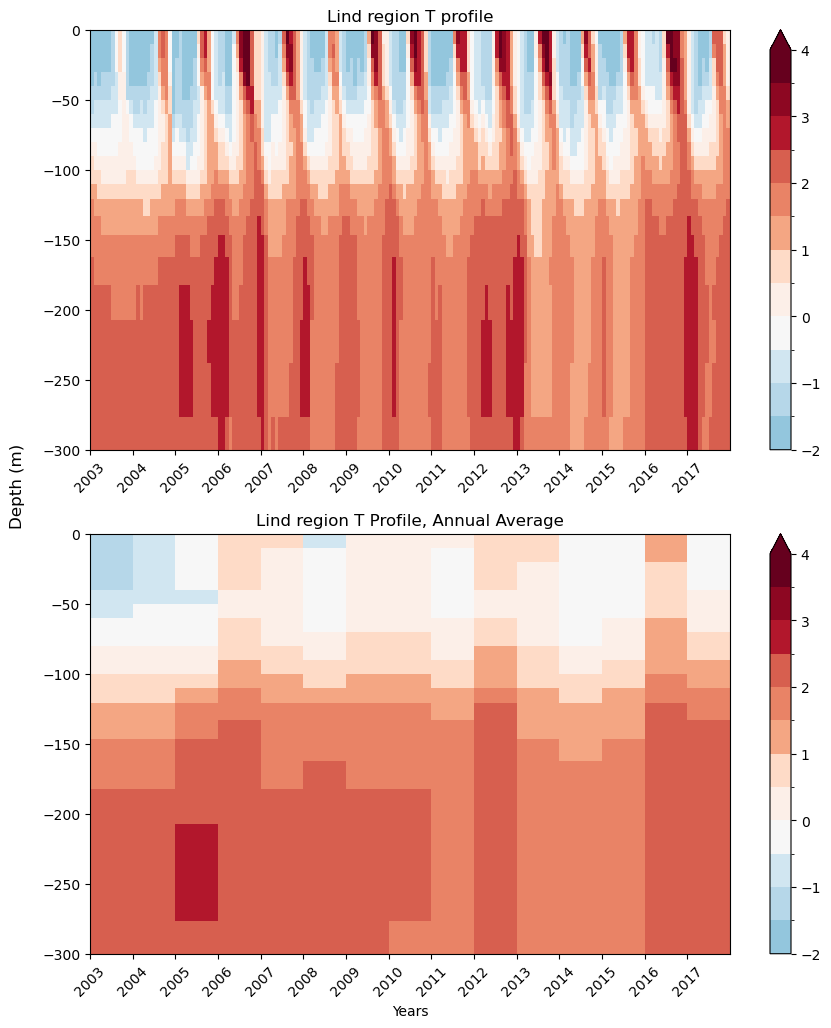

In [16]:
XVc,YVc = np.meshgrid(np.arange(181),mygrid['RF'])
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(bounds, ncolors=cmap.N, clip=True)

# First plot: full Northern Subsection
fig = plt.figure(figsize=(10,12))

ax = plt.subplot(211)
cb = ax.pcolormesh(XVc, YVc, thetaprofile,cmap=cmap,norm=norm)
ax.set_ylim(-300,0)
ax.set_title("Lind region T profile")
plt.colorbar(cb,extend="max")
xtick_positions = np.arange(0, 180, 12)  # Every 12 months
xtick_labels = np.arange(2003, 2018)  # Years from 2003 to 2017
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, rotation=45)  # Rotate for readability

# fix the labels
fig.supylabel("Depth (m)")
fig.subplots_adjust(left=0.1)  # Increase left margin (default ~0.125)


ax = plt.subplot(212)

# make the profiles for each plot, do the total year, ice growth, then ice decline proifile
thetaprofile_reshaped = thetaprofile.reshape(50,15,12)

thetaprofile_avg = np.nanmean(thetaprofile_reshaped, axis=2)  # Shape: (50, 15)
XVc,YVc = np.meshgrid(np.arange(16),mygrid['RF'])

cb = ax.pcolormesh(XVc, YVc, thetaprofile_avg,cmap=cmap,norm=norm)
ax.set_ylim(-300,0)
ax.set_title("Lind region T Profile, Annual Average")
plt.colorbar(cb,extend="max")
xtick_positions = np.arange(0, 15, 1)  # Every 12 months
xtick_labels = np.arange(2003, 2018)  # Years from 2003 to 2017
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, rotation=45)  # Rotate for readability

# fix the labels
ax.set_xlabel("Years")
fig.supylabel("Depth (m)")
fig.subplots_adjust(left=0.1)  # Increase left margin (default ~0.125)

# plt.savefig("Lind1c_totalTprofile_2sets.png",dpi=300)

In [17]:
thetaprofile_avg.shape

(50, 15)

In [18]:
# ID the ArW layer
min_temps = np.nanmin(thetaprofile_avg, axis=0)  # Minimum temperature for each year
min_temp_indices = np.nanargmin(thetaprofile_avg, axis=0)  # Shape: (15,)
min_temp_depths = (YVc[min_temp_indices][:,0] + YVc[min_temp_indices+1][:,0])/2

# ID the AW layer
AWcopy = np.full(thetaprofile_avg.shape,np.nan)
for i in range(len(min_temp_indices)):
    myi = min_temp_indices[i]
    AWcopy[myi:,i] = thetaprofile_avg[myi:,i]
max_temps = np.nanmax(AWcopy,axis=0)
max_temp_indices = np.nanargmax(AWcopy,axis=0)
max_temp_depths = (YVc[max_temp_indices][:,0] + YVc[max_temp_indices+1][:,0])/2

# ID the surface layer, if it exists
surfcopy = np.full(thetaprofile_avg.shape,np.nan)
for i in range(len(min_temp_indices)):
    myi = min_temp_indices[i]
    surfcopy[:myi,i] = thetaprofile_avg[:myi,i]
    
max_temps = np.nanmax(surfcopy,axis=0)
print(max_temps)
max_temp_indices = np.array([])
i = 0
for temp in max_temps:
    if np.isnan(temp):
        max_temp_indices = np.append(max_temp_indices,0)
    else:
        max_temp_indices = np.append(max_temp_indices,int(np.nanargmax(surfcopy[:,i]) ) )
    i += 1

max_temp_indices = max_temp_indices.astype(int)

max_temp_depths_surf = (YVc[max_temp_indices][:,0] + YVc[max_temp_indices+1][:,0])/2

[        nan         nan -0.31669522  0.84719014  0.51243742         nan
  0.08438666  0.44990677  0.03588164  0.70149562  0.61416103 -0.2760169
 -0.07168099  1.11371465 -0.06433038]


In [19]:
# get the midpoint between these two layers
mid_ArW_AW = (min_temp_depths+max_temp_depths)/2
mid_surf_ArW = (max_temp_depths_surf+min_temp_depths)/2

In [27]:
len(bounds)

13

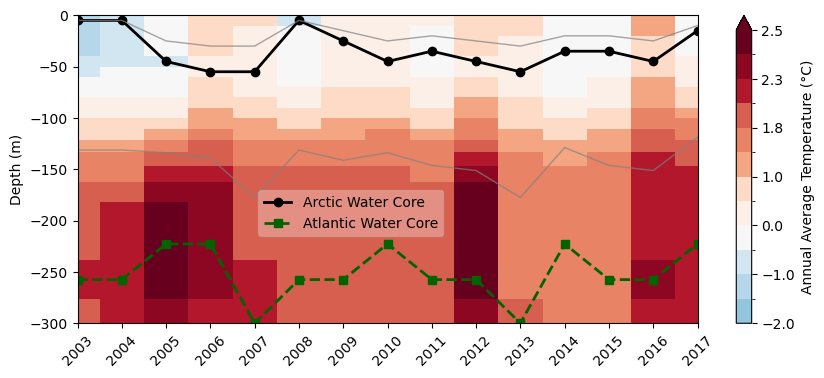

In [54]:
bounds = [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.4, 1.8, 2.1, 2.3, 2.4, 2.5]
colors = ["#93c6dd","#b6d7e9","#d1e6f1","#f7f7f7","#fcefe8","#fedbc7","#f4a683","#e98366","#d75f4f","#b2172c","#8d0722","#66001e"]
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(bounds, ncolors=cmap.N, clip=True)

ax = plt.subplot(111)

# make the profiles for each plot, do the total year, ice growth, then ice decline proifile
thetaprofile_reshaped = thetaprofile.reshape(50,15,12)

thetaprofile_avg = np.nanmean(thetaprofile_reshaped, axis=2)  # Shape: (50, 15)
XVc,YVc = np.meshgrid(np.arange(16),mygrid['RF'])

cb = ax.pcolormesh(XVc, YVc, thetaprofile_avg,cmap=cmap,norm=norm)
ax.set_ylim(-300,0)
# ax.set_title("Lind region T Profile, Annual Average")
cbar = plt.colorbar(cb,extend="max")
cbar.set_label("Annual Average Temperature (°C)")

xtick_positions = np.arange(0.5, 15.5, 1)  # Every 12 months
xtick_labels = np.arange(2003, 2018)  # Years from 2003 to 2017
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, rotation=45)  # Rotate for readability

# fix the labels
# ax.set_xlabel("Years")
fig.supylabel("Depth (m)")
fig.subplots_adjust(left=0.1)  # Increase left margin (default ~0.125)


# add the lines
# Overlay lines for key temperature depths
ax.plot(np.arange(0.5,15.5), min_temp_depths, color='black', marker='o', linestyle='-', label="Arctic Water Core",markersize=6,linewidth=2)
ax.plot(np.arange(0.5,15.5), max_temp_depths, color='darkgreen', marker='s', linestyle='--', label="Atlantic Water Core",markersize=6,linewidth=2)

# plot the midpoint lines
ax.plot(np.arange(0.5,15.5), mid_ArW_AW, color='gray', alpha=0.7, linestyle='-',linewidth=1)
ax.plot(np.arange(0.5,15.5), mid_surf_ArW, color='gray', alpha=0.7, linestyle='-',linewidth=1)

plt.xlim(0.5,14.5)
plt.ylabel("Depth (m)")

# ax.legend(loc="lower left", bbox_to_anchor=(0, 0.6), facecolor='white', framealpha=0.3)
ax.legend(loc="lower left", bbox_to_anchor=(0.28, 0.26), facecolor='white', framealpha=0.3)

plt.savefig("LindFig1c_v2.png",dpi=300)

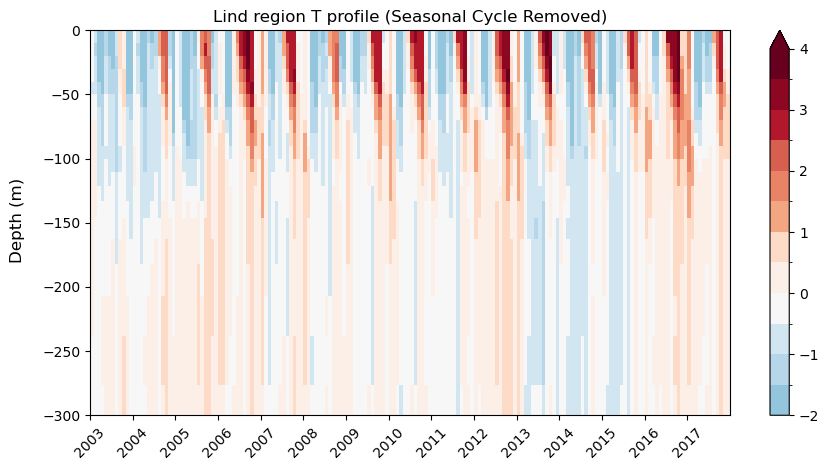

In [22]:
# Assume thetaprofile is of shape (depth, months * years) i.e., (N_depth, 180)
n_months = 12
n_years = thetaprofile.shape[1] // n_months  # Assuming 15 years (2003-2017)

# Reshape into (depth, months, years) -> shape (N_depth, 12, 15)
thetaprofile_reshaped = thetaprofile.reshape(thetaprofile.shape[0], n_months, n_years)

# Compute the monthly climatology (average across years for each month)
monthly_climatology = np.mean(thetaprofile_reshaped, axis=2)  # Shape (N_depth, 12)

# Expand climatology back to (N_depth, 180) by repeating across years
seasonal_cycle = np.tile(monthly_climatology, (1, n_years))

# Remove the seasonal cycle
thetaprofile_deseasoned = thetaprofile - seasonal_cycle

# ---- Plot the deseasoned data ----
XVc, YVc = np.meshgrid(np.arange(181), mygrid['RF'])
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(bounds, ncolors=cmap.N, clip=True)

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
cb = ax.pcolormesh(XVc, YVc, thetaprofile_deseasoned, cmap=cmap, norm=norm)
ax.set_ylim(-300, 0)
ax.set_title("Lind region T profile (Seasonal Cycle Removed)")
plt.colorbar(cb, extend="max")

xtick_positions = np.arange(0, 180, 12)  # Every 12 months
xtick_labels = np.arange(2003, 2018)  # Years from 2003 to 2017
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, rotation=45)  # Rotate for readability

fig.supylabel("Depth (m)")
fig.subplots_adjust(left=0.1)  # Increase left margin (default ~0.125)
plt.show()


In [238]:
allyears[1:7]

array([2004, 2005, 2006, 2007, 2008, 2009])

In [228]:
np.nanmean(allTHETA[:5], axis=(0,2,3)).shape

(50,)

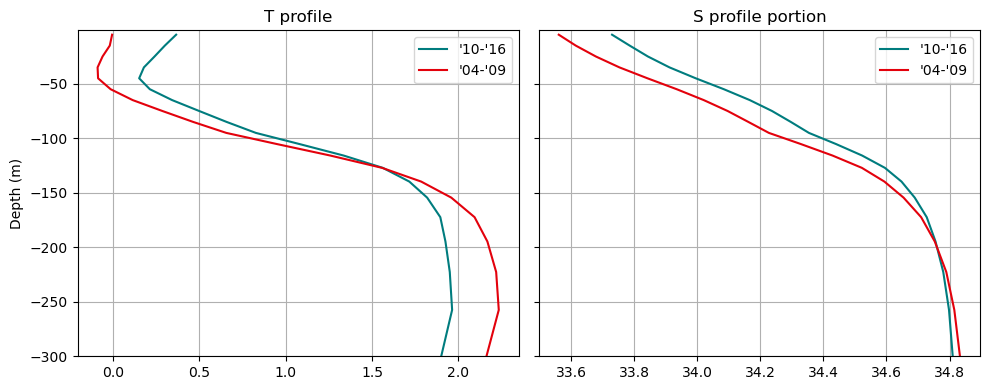

In [242]:
# plot the vertical profiles for the two sections

# colors
c1 = '#007c7e'
c2 = '#edaf02'
c3 = '#e3010c'

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex='col', sharey=True)

# First plot: Temperature profile for Southern portion
axes[0].plot(np.nanmean(thetaprofile_reshaped[:,7:-1,:], axis=(1,2)), mygrid['RC'], label="'10-'16",color=c1)
axes[0].plot(np.nanmean(thetaprofile_reshaped[:,1:7,:], axis=(1,2)), mygrid['RC'], label="'04-'09",color=c3)
axes[0].set_ylim(-300, -1)
axes[0].set_title("T profile")
axes[0].legend()
axes[0].grid()
axes[0].set_ylabel("Depth (m)")  # Y-axis label

# Second plot: Salinity profile for Southern portion
axes[1].plot(np.nanmean(allSALT[7:-1], axis=(0,2,3)), mygrid['RC'], label="'10-'16",color=c1)
axes[1].plot(np.nanmean(allSALT[1:7], axis=(0,2,3)), mygrid['RC'], label="'04-'09",color=c3)
axes[1].set_ylim(-300, -1)
axes[1].set_title("S profile portion")
axes[1].legend()
axes[1].grid()

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig("profiles_Lindfig2dh.png", dpi=300)

# print("Profiles saved to 'profiles.png'")

In [243]:
def identify_ocean_layers(T):
    """
    Identify Surface, Arctic, and Atlantic layers based on temperature extrema
    for a dataset with a time dimension.
    
    Parameters:
    T (numpy array): Temperature array of shape (months, nz, ny, nx).

    Returns:
    dict: Containing depth indices of each layer for each month.
    """
    months, nz, ny, nx = T.shape

    # Identify Arctic Layer (T min per month, per (y, x) profile)
    z_arctic_idx = np.argmin(T, axis=1)  # Shape: (months, ny, nx)

    # Identify Atlantic Layer (T max **only below Arctic Layer**)
    atlantic_mask = np.arange(nz)[None, :, None, None] > z_arctic_idx[:, None, :, :]  # Mask below Arctic
    T_atlantic_layer = np.where(atlantic_mask, T, -np.inf)  # Ignore above-Arctic temperatures
    z_atlantic_idx = np.argmax(T_atlantic_layer, axis=1)  # Find max T below Arctic

    # Identify Surface Layer (Max T **above Arctic Layer**, if it exists)
    surface_mask = np.arange(nz)[None, :, None, None] < z_arctic_idx[:, None, :, :]  # Mask above Arctic
    T_surface_layer = np.where(surface_mask, T, -np.inf)  # Ignore values below Arctic Layer
    z_surface_idx = np.argmax(T_surface_layer, axis=1)  # Find max T above Arctic

    # Handle cases where no valid surface layer exists (e.g., Arctic Layer is at surface)
    z_surface_idx[z_surface_idx >= z_arctic_idx] = 0

    print(z_arctic_idx.shape,z_atlantic_idx.shape,z_surface_idx.shape)

    # do the midpoints to create the mask
    z_surface_arctic_mid = (z_surface_idx + z_arctic_idx) // 2
    z_arctic_atlantic_mid = (z_arctic_idx + z_atlantic_idx) // 2
    
    # Create a mask initialized with zeros
    mask = np.zeros((months, nz, ny, nx), dtype=int)

    # Expand dimensions to match (months, nz, ny, nx)
    depth_levels = np.arange(nz)[None, :, None, None]  # Shape: (1, nz, 1, 1)
    z_surface_arctic_mid = z_surface_arctic_mid[:, None, :, :]  # Shape: (months, 1, ny, nx)
    z_arctic_atlantic_mid = z_arctic_atlantic_mid[:, None, :, :]  # Shape: (months, 1, ny, nx)

    # Assign layer values to mask
    mask[depth_levels <= z_surface_arctic_mid] = 1  # Surface Layer
    mask[(depth_levels > z_surface_arctic_mid) & (depth_levels <= z_arctic_atlantic_mid)] = 2  # Arctic Layer
    mask[depth_levels > z_arctic_atlantic_mid] = 3  # Atlantic Layer

    return mask

# Example usage:
# layers = identify_ocean_layers(THETADR, depths)

In [ ]:
# we can do this from lind2018_fig2